# Review : Image Style Transfer Using Convolutional Neural Networks
+ 딥러닝을 이용하여 style을 합성을 시도한 초기 모델.

## 0. 딥러닝 모델
+ 사전에 학습되어있는 VGG-19를 사용.
+ 이중에서 5개의 conv계층 가져옴.
+ 노이즈($\vec{x}$)와 실제 이미지 사이의 loss를 줄여 노이즈를 실제 이미지로 변환하는 과정으로 추론.

## 1. 목적함수
<img src="https://drive.google.com/uc?id=1PxKsV4__Tsph3YBuypGLJt81cmgd1eQC" width=500>  
+ p : content data, a : style data, x : noise data

+ 각각의 loss를 설계하는데에 있어서 CNN의 feature map의 성질을 적극 활용하였다.
    + 층이 깊어질 수록, chanel수는 증가하고, filter크기는 감소한다!
    + 층이 깊어질 수록, style은 많이 담고, content는 적게담는다!
+ content는 filter에서의 구체적인 값, style은 filter간의 분포도 값에 대응 시켰다.  
<img src="https://drive.google.com/uc?id=1awDqxABAssnvLzdJ_1_2QTkPFmojkKrk" height=350>  

<img src="https://drive.google.com/uc?id=1Z7B3gAPa8-gjlBgAJiQQLO_OMLlz-u4N" height=400>  

$F^l \in R^{N_l \times M_l}$  

앞으로 이 값들을 계속해서 사용한다.

### 1.1 Content Loss
+ 그림의 내용(물체의 형태, 위치)에 대한 목적함수

$$L_{content}(\vec{p}, \vec{x}, l) = \cfrac{1}{2} \sum_{i, j}({F^l_{ij} - P^l_{ij}})^2$$  

+ p : 입력이미지, x : 노이즈
+ P : 입력결과값, F : 노이즈결과값
+ 이미지 feature 위치가 같아지도록 한다고 볼 수 있다.


### 1.2 Style Loss
+ 그림의 스타일에 대한 목적함수
    + Gram matrix
$$G^l \in R^{N_l \times N_l}$$
$$G^l_{ij} = \sum_k{F^l_{ik} F^l_{jk}}$$  
        + $l$번째 레이어의 $i$와$j$번째 feature map의 correlation을 파악하는 척도.
        + matrix의 크기는 각 layer의 filter개수에 비례한다. 즉, 층이 깊어질 수록 Gram matrix의 크기가 커진다.
<img src="https://drive.google.com/uc?id=1USH78TL0w3uooFEcmDqBQLdgPc-3KV-0" height=100>

    + Loss function
$$E_l = \cfrac{1}{4N^2_l M^2_l}\sum_{i, j}{(G^l_{ij} - A^l_{ij})}$$
$$L_{style}(\vec{a}, \vec{x}) = \sum^L_{l=0}{w_l E_l})$$
        + a : 입력이미지, x : 노이즈
        + A : 입력결과값, G : 노이즈 결과값
        + 앞의 분수 : 값 정규화(너무 크지않도록)
        + $w_l$ : 각 레이어에 대해 가중치 부여(하이퍼파라미터) 
        + 논문에서는 사용할 layer개수로 산술평균냄.(wl = 1/5)
        + __손실함수 E를 보았을 때, 각 layer에 대한 gram matrix를 구하고 matrix 값을 비교하고 있다. 즉, filter간의 상관 관계 "결과값"을 비교하는 것이므로, 각 filter 내부에서 값요소가 같을 필요는 없고(이게 같은건 content정보를 담겠다는 뜻...), 각 layer 에서 filter 끼리의 값 관계가 (G, A) 닮아야한다!__

### 모델 분석

<img src="https://drive.google.com/uc?id=1njU1K0jQfLRpuN2xlfTc_RMEIdrQ4qdf">

+ style loss
    + style 이미지를 CNN모델에 쭉쭉 보내고, 각 layer에대해 Gram matrix계산. 노이즈에 대해서도 마찬가지로 계산.
    + 각각의 오차를 합한 것이 style loss

+ content loss
    + content 이미지를 CNN모델에 쭉쭉 보내고, 노이즈에도 쭉쭉 보냄.
    + 모든 feature에 대해 오차 합한 것이 content loss

+ total loss
    + style, content loss를 합한 후 노이즈의 gradient descent를 구해서 최적화한다.

+ layer가 낮을 수록 content정보를 많이 갖고있고, 깊을 수록 style정보를 많이 담는 것을 알 수 있다.



### 내 생각
+ style은 첫번째층부터 순차적으로 쌓는이유는, 결국에 정보를 최대한 많이 얻어야하고, noise 갱신하는 과정에서 기울기 손실? 줄이기 위해 다 사용
+ content는 각 layer마다 filter가 담고있는 정보가 다르므로(선, texture, object 등으로..) 서로간의 정보개입을 최대한 줄이기 위함이 아닌가 싶다...

# 코드 실습


## 라이브러리 호출 및 환경설정

In [ ]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import PIL
import matplotlib.pyplot as plt

import copy

In [ ]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 이미지를 불러와 다운받아 텐서(Tensor) 객체로 변환하는 함수
def image_loader(img_path, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize), # 이미지의 크기를 변경
        transforms.ToTensor() # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
    ])
    image = PIL.Image.open(img_path)
    # 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)
    plt.show()

### Image Reconstruction 실습
+ 이미지를 손실값을 낮추는 방향으로 업데이트 하는것.
+ MSE사용

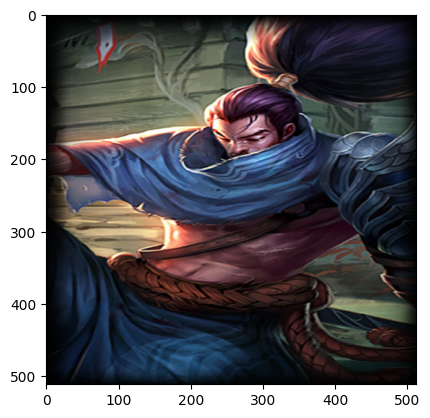

In [ ]:
# 목표 이미지(target image) 불러오기
img_path = './yasuo.jpg'
target_image = image_loader(img_path, (512, 512))
imshow(target_image)

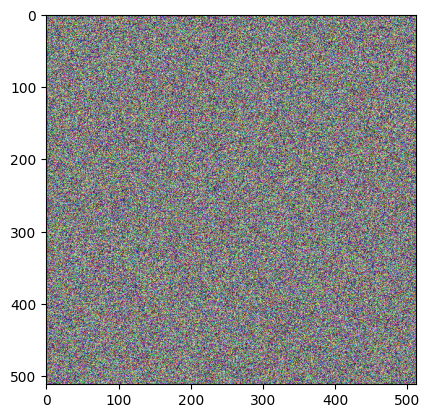

In [ ]:
# 동일한 크기의 노이즈 이미지 준비하기
noise = torch.empty_like(target_image).uniform_(0, 1).to(device)
imshow(noise)

In [ ]:
loss = nn.MSELoss()
iters = 100
lr = 1e4

print("[ Start ]")
imshow(noise)

for i in range(iters):
    # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
    noise.requires_grad = True

    # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
    output = loss(noise, target_image)
    output.backward()

    # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
    gradient = lr * noise.grad
    # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
    noise = torch.clamp(noise - gradient, min=0, max=1).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    if (i + 1) % 10 == 0:
        print(f'[ Step: {i + 1} ]')
        print(f'Loss: {output}')
        imshow(noise)

Output hidden; open in https://colab.research.google.com to view.

### 실습할 이미지 불러오기


[ Content Image ]


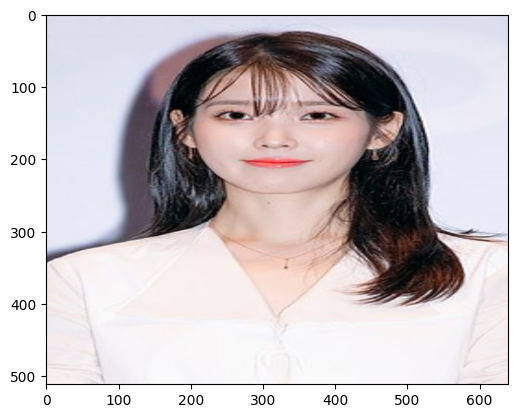

[ Style Image ]


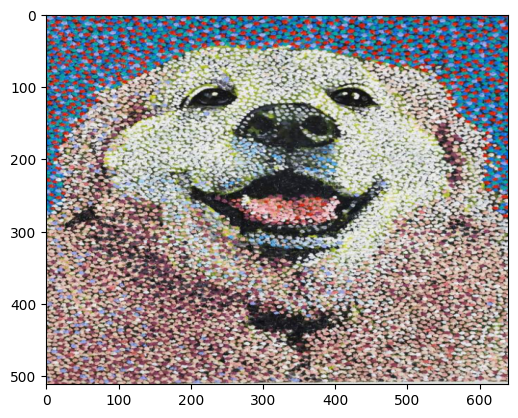

In [ ]:
content_img = image_loader('./iu_content_1.jpg', (512, 640))
style_img = image_loader('./plot_style.jpg', (512, 640))

print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

### CNN 네트워크 불러오기.
+ 사전학습된 VGG19 모델 불러옴

In [ ]:
# vgg의 사전학습가중치로 모델 초기화하고, 평가모델로 일정한 출력 갖도록 설정.
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 67.2MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# vgg모델에 이미지 입력할 때, 정규화해서 넣도록 설정되어있으므로 입력 초기화 구현

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

### Style Reconstruction 구현
+ 주어진 noise를 특정 스타일의 이미지로 변하도록 구현

In [ ]:
def gram_matrix(input):
    # a는 배치 크기, N는 특징 맵의 개수, (h, w)는 특징 맵의 차원을 의미
    a, N, h, w = input.size()
    # 논문에서는 i = 특징 맵의 개수, j = 각 위치(position)
    features = input.view(a * N, h * w)
    # 행렬 곱으로 한 번에 Gram 내적 계산 가능
    G = torch.mm(features, features.t())
    # Normalize 목적으로 값 나누기
    return G.div(a * N * h * w)

    
# 스타일 손실(style loss) 계산을 위한 클래스 정의
# target을 초기화시켜서 gram_matrix만든다(A)
# input을 집어넣고 gram_matrix화 시킨다.(G)
# 둘 사이의 mse계산

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# 스타일 손실(style loss)을 계산하는 함수
def get_style_losses(cnn, style_img, noise_image):
    # 사전훈련된 vgg 모델 가져온다.
    cnn = copy.deepcopy(cnn)
    # 입력에 맞게 정규화
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    # model에다가 해당하는 층 이름 바꿔서 넣는다.
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 style loss 이후의 레이어는 사용하지 않도록
    
    # 메모리사용량, 계산시간 줄이기 위해 (실제로 vgg모델에는 16개의 conv층이 있지만, 여기선 5개만 사용한다.)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            model = model[:(i + 1)]
            break
        
    return model, style_losses

In [ ]:
def style_reconstruction(cnn, style_img, input_img, iters):
    model, style_losses = get_style_losses(cnn, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    # global, local변수 문제때문에 걍 리스트로 저장해놓은듯.
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0

            for sl in style_losses:
                style_score += sl.loss

            # 가중치 곱해주는데,,, 다 똑같이하면 왜하는겨,,,
            style_score *= 1e6
            style_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

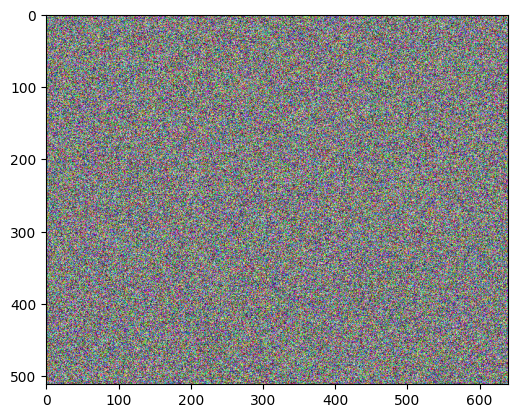

In [ ]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

In [ ]:
# style reconstruction 수행
output = style_reconstruction(cnn, style_img=style_img, input_img=input_img, iters=300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
style_layers = ['conv_1']
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
# style reconstruction 수행
output = style_reconstruction(cnn, style_img=style_img, input_img=input_img, iters=300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
style_layers = ['conv_4']
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
# style reconstruction 수행
output = style_reconstruction(cnn, style_img=style_img, input_img=input_img, iters=300)

Output hidden; open in https://colab.research.google.com to view.

### Content reconstruction 실습


In [ ]:
# 콘텐츠 손실(content loss) 계산을 위한 클래스 정의
# 앞에서의 손실 구하는 것과 동일.
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
# 여기서 원하는 층을 바꾸면 다른 층으로 실습해볼 수 있음!
content_layers = ['conv_4']

# 콘텐츠 손실(content loss)을 계산하는 함수
# 앞에서 style loss 함수랑 똑같다.
def get_content_losses(cnn, content_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)
    
    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

    # 마지막 content loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss):
            model = model[:(i + 1)]
            break

    
    return model, content_losses

In [ ]:
def content_reconstruction(cnn, content_img, input_img, iters):
    model, content_losses = get_content_losses(cnn, content_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0

            for cl in content_losses:
                content_score += cl.loss

            content_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()}]")
                imshow(input_img)
            
            return content_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)

# content reconstruction 수행
output = content_reconstruction(cnn, content_img=content_img, input_img=input_img, iters=300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_layers = ['conv_1']
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
# content reconstruction 수행
output = content_reconstruction(cnn, content_img=content_img, input_img=input_img, iters=300)

Output hidden; open in https://colab.research.google.com to view.

__깊은, 얕은 층의 차이에 따라 reconstruction의 정도가 다르다!!__  
__style은 더 깊을수록, content는 더 얕을수록 정확한 경향__

<img src="https://drive.google.com/uc?id=16WJ4ht_kShqiLpsCXSgtYLTVgdhNwNqc" height = 500>

### Style Transfer 실습


In [ ]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Style Transfer 손실(loss)을 계산하는 함수
def get_losses(cnn, content_img, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

In [ ]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

[ Content Image ]


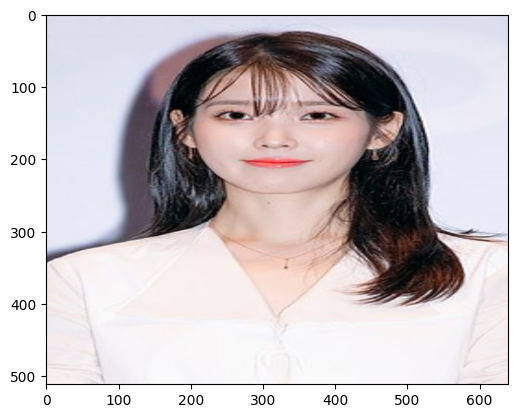

[ Style Image ]


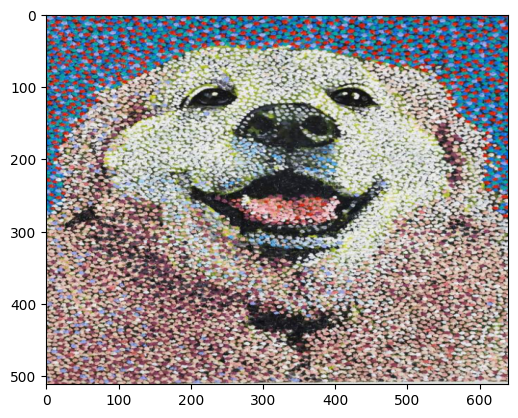

In [ ]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 모두 준비합니다.
content_img = image_loader('./iu_content_1.jpg', (512, 640))
style_img = image_loader('./plot_style.jpg', (512, 640))
print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

In [ ]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)

# style transfer 수행
output = style_transfer(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=900)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_7', 'conv_9']
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)

# style transfer 수행
output = style_transfer(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=900)

Output hidden; open in https://colab.research.google.com to view.